<a href="https://colab.research.google.com/github/Sg-27/Optical-Character-Recognition/blob/main/Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2 :: Optical Character Recognition -- Soumyadeep Ghosh (20EC39035) and Shrija Karmakar(20EC39034)

Part 1: Training a Resnet9 Network on MNIST Dataset

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(f"We are training on {device} for this experiment")

assert 'cuda' in repr(device), "GPU is not selected in hardware accelerator dropdown"

We are training on cuda:0 for this experiment


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
your_google_drive_path = "/content/drive/MyDrive/checkpointss/"
import os
assert os.path.isdir(your_google_drive_path), f"{your_google_drive_path} is not a valid location"

In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 4

#Getting dataset class object corresponding to train split
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

#Creating data loader from train dataset object
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#Getting dataset class object corresponding to test split
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

#Creating data loader from test dataset object
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

100%|██████████| 9912422/9912422 [00:00<00:00, 75537815.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40745272.06it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23892885.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3495509.87it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



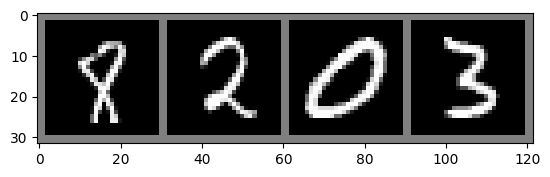

eight two   zero  three


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch
import torch.nn as nn


# Define the basic block for the ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet-9 model
class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.block1 = BasicBlock(64, 128, stride=1)
        self.block2 = BasicBlock(128, 256, stride=1)
        self.block3 = BasicBlock(256, 512, stride=1)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet9().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def validator(testloader=None,net=None):
    correct = 0
    total = 0
    net.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            # perform max along dimension 1, since dimension 0 is batch dimension
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return correct/total

In [ ]:
start_epoch=0
end_epoch=5


In [ ]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    current_accuracy = validator(testloader=testloader,net=model)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             your_google_drive_path+'best_model.pth')

    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'checkpoint.pth')



print('Finished Training')

[1,  2000] loss: 0.848
[1,  4000] loss: 0.253
[1,  6000] loss: 0.162
[1,  8000] loss: 0.126
[1, 10000] loss: 0.102
[1, 12000] loss: 0.076
[1, 14000] loss: 0.078
Accuracy of the network on the 10000 test images: 98 %
[2,  2000] loss: 0.185
[2,  4000] loss: 0.104
[2,  6000] loss: 0.071
[2,  8000] loss: 0.070
[2, 10000] loss: 0.059
[2, 12000] loss: 0.055
[2, 14000] loss: 0.059
Accuracy of the network on the 10000 test images: 98 %
[3,  2000] loss: 0.051
[3,  4000] loss: 0.043
[3,  6000] loss: 0.039
[3,  8000] loss: 0.036
[3, 10000] loss: 0.043
[3, 12000] loss: 0.040
[3, 14000] loss: 0.036
Accuracy of the network on the 10000 test images: 99 %
[4,  2000] loss: 0.029
[4,  4000] loss: 0.036
[4,  6000] loss: 0.033
[4,  8000] loss: 0.029
[4, 10000] loss: 0.026
[4, 12000] loss: 0.036
[4, 14000] loss: 0.031
Accuracy of the network on the 10000 test images: 98 %
[5,  2000] loss: 0.026
[5,  4000] loss: 0.025
[5,  6000] loss: 0.031
[5,  8000] loss: 0.025
[5, 10000] loss: 0.029
[5, 12000] loss: 0.02

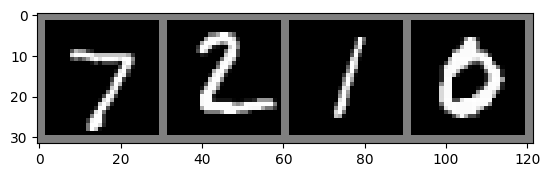

GroundTruth:  seven two   one   zero 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net_best = ResNet9().to(device)
checkpoint = torch.load(your_google_drive_path+'best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  seven two   one   zero 


Part 2 : Builiding Custom Dataset

In [ ]:
your_google_drive_path = "/content/drive/MyDrive/Custom Dataset/"
import os
assert os.path.isdir(your_google_drive_path), f"{your_google_drive_path} is not a valid location"

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms

In [ ]:
class CustomDigitsDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.data, self.labels = self.load_data()


    def load_data(self):
        data = []
        labels = []
        digit_folders = sorted(os.listdir(self.root_folder))

        for label, digit_folder in enumerate(digit_folders):
            digit_path = os.path.join(self.root_folder, digit_folder)
            for image_name in os.listdir(digit_path):
                image_path = os.path.join(digit_path, image_name)
                img = Image.open(image_path).convert('L')  # Convert to grayscale


                data.append(img)
                labels.append(label)
                #print(label)

        return data, labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(32,32)),
    transforms.Normalize((0.5),(0.5)),
    transforms.RandomInvert(1)

])
batch_size=4

# Specify the path to the root folder containing digit folders

your_google_drive_path='/content/drive/MyDrive/Custom Dataset'
custom_dataset = CustomDigitsDataset(your_google_drive_path, transform=transform)

# Split the dataset into training and testing sets
print(len(custom_dataset))
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Example usage:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

540


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 1, 32, 32])


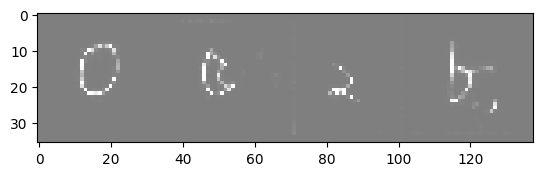

zero  five  two   eight


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
classes = ('zero', 'one', 'two', 'three',
           'four', 'five','six','seven','eight','nine')
# show imagesname.startswith('block3') or
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Part 4: Transfer Learning with Fine Tuning

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet9().to(device)
# Freeze all layers of the pre-trained ResNet9 model except the final fully connected layer
# for name, param in model.named_parameters():
#     if name.startswith('fc'):  # Unfreeze only the parameters of the fully connected layer
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
params_update = []
for name, param in model.named_parameters():
    if name.startswith('block3') or name.startswith('fc'):
    #if name.startswith('block1') or name.startswith('block2') or name.startswith('block3') or name.startswith('fc'):
    #if name.startswith('fc'):
        param.requires_grad = True
        params_update.append(param)
    else:
        param.requires_grad = False
    print(name)

conv1.weight
bn1.weight
bn1.bias
block1.conv1.weight
block1.bn1.weight
block1.bn1.bias
block1.conv2.weight
block1.bn2.weight
block1.bn2.bias
block1.shortcut.0.weight
block1.shortcut.1.weight
block1.shortcut.1.bias
block2.conv1.weight
block2.bn1.weight
block2.bn1.bias
block2.conv2.weight
block2.bn2.weight
block2.bn2.bias
block2.shortcut.0.weight
block2.shortcut.1.weight
block2.shortcut.1.bias
block3.conv1.weight
block3.bn1.weight
block3.bn1.bias
block3.conv2.weight
block3.bn2.weight
block3.bn2.bias
block3.shortcut.0.weight
block3.shortcut.1.weight
block3.shortcut.1.bias
fc.weight
fc.bias


In [ ]:
for name, param in model.named_parameters():
    #if name.startswith('block3') or name.startswith('fc'):

        if param.requires_grad == True:
            print(name)


block3.conv1.weight
block3.bn1.weight
block3.bn1.bias
block3.conv2.weight
block3.bn2.weight
block3.bn2.bias
block3.shortcut.0.weight
block3.shortcut.1.weight
block3.shortcut.1.bias
fc.weight
fc.bias


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(params_update, lr=0.001, momentum=0.9)

In [ ]:
list(model.parameters())

In [ ]:
def validator(test_loader=None,model=None):
    correct = 0
    total = 0
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            # perform max along dimension 1, since dimension 0 is batch dimension
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 540 test images: {100 * correct // total} %')
    return correct/total

In [ ]:
your_google_drive_path="/content/drive/MyDrive/checkpoint2/"

In [ ]:
start_epoch=0
end_epoch=40

In [ ]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    current_accuracy = validator(test_loader=test_loader,model=model)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             your_google_drive_path+'best_model.pth')

    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'checkpoint.pth')



print('Finished Training')

Accuracy of the network on the 540 test images: 10 %
Accuracy of the network on the 540 test images: 24 %
Accuracy of the network on the 540 test images: 26 %
Accuracy of the network on the 540 test images: 25 %
Accuracy of the network on the 540 test images: 47 %
Accuracy of the network on the 540 test images: 67 %
Accuracy of the network on the 540 test images: 68 %
Accuracy of the network on the 540 test images: 55 %
Accuracy of the network on the 540 test images: 79 %
Accuracy of the network on the 540 test images: 75 %
Accuracy of the network on the 540 test images: 84 %
Accuracy of the network on the 540 test images: 71 %
Accuracy of the network on the 540 test images: 79 %
Accuracy of the network on the 540 test images: 75 %
Accuracy of the network on the 540 test images: 90 %
Accuracy of the network on the 540 test images: 80 %
Accuracy of the network on the 540 test images: 85 %
Accuracy of the network on the 540 test images: 87 %
Accuracy of the network on the 540 test images

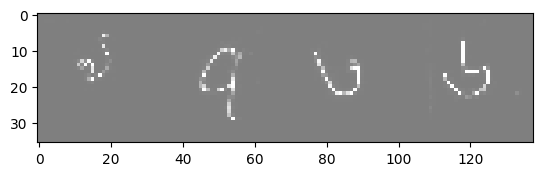

nine  seven three six  


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = next(dataiter)

images, labels = next(dataiter)
images, labels = next(dataiter)
batch_size=4

# print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
net_best = ResNet9().to(device)
checkpoint = torch.load(your_google_drive_path+'best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  two   zero  zero  five 


In [ ]:
print(param.requires_grad)

True
